#### Resources
[Paper on CA FWI](https://cfs.nrcan.gc.ca/pubwarehouse/pdfs/31168.pdf)

[National Wildfire Coordinating Group](https://www.nwcg.gov/publications/pms437/cffdrs/fire-weather-index-fwi-system)

In [1]:
# Standard Data Science/Analysis Toolkit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use("ggplot")
import seaborn as sns

# Machine Learning Tools, Utilities, and Scoring Metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Suite of Machine Learning Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression

# Setup to Ignore Version Errors and Deprecations
import warnings
warnings.filterwarnings("ignore")

Access our data set. We found this from [kaggle](https://www.kaggle.com/datasets/elikplim/forest-fires-data-set/data)

In [2]:
df = pd.read_csv('data/forestfires.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


Looks like no null values, but we will have to check later if there are non-null values that are skewing data.

In [3]:
df.head(3)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0


### Let's add the BUI and FWI columns

In [64]:
df['BUI'] = df['DMC'] + df['DC']
df['FWI'] = df['ISI'] + df['BUI']

### Rearrange our columns

I'm arranging these in their order that works towards Fire Weather Index (FWI)

FFMC + Wind = ISI(which is already a value in the table)\
DMC + DC = BUI (Build Up Index)\
BUI + ISI = FWI


In [78]:
cols = list(df.columns.values)
df = df[['X', 'Y',
 'month', 'day',
 'FFMC', 'wind', 'ISI',
 'DMC', 'DC', 'BUI',
 'FWI',
 'RH',
 'rain',
 'temp',
 'area',
 'log_burned_area']]

RH (Relative Humidity), Temperature, Rain, and Wind are all used to calculate FFMC, DMC, DC with Wind being a unit required to determine ISI. So let's drop those three values since they aren't needed. 

In [68]:
df_cleaned = df.drop(['rain', 'temp', 'RH'], axis=1)

In [69]:
df_cleaned.describe()

,X,Y,month_num,day_num,FFMC,wind,ISI,DMC,DC,BUI,FWI,area,log_burned_area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,7.475822,4.259188,90.644681,4.017602,9.021663,110.872340,547.940039,658.812379,667.834043,12.847292,1.111026
std,2.313778,1.229900,2.275990,2.072929,5.520111,1.791653,4.559477,64.046482,248.066192,295.492453,296.703818,63.655818,1.398436
min,1.000000,2.000000,1.000000,1.000000,18.700000,0.400000,0.000000,1.100000,7.900000,10.900000,14.400000,0.000000,0.000000
25%,3.000000,4.000000,7.000000,2.000000,90.200000,2.700000,6.500000,68.600000,437.700000,541.900000,549.600000,0.000000,0.000000
50%,4.000000,4.000000,8.000000,5.000000,91.600000,4.000000,8.400000,108.300000,664.200000,766.100000,781.900000,0.520000,0.418710
75%,7.000000,5.000000,9.000000,6.000000,92.900000,4.900000,10.800000,142.400000,713.900000,844.300000,854.100000,6.570000,2.024193
max,9.000000,9.000000,12.000000,7.000000,96.200000,9.400000,56.100000,291.300000,860.600000,1151.900000,1155.900000,1090.840000,6.995620


Let's check out the features with 0 as a min. 

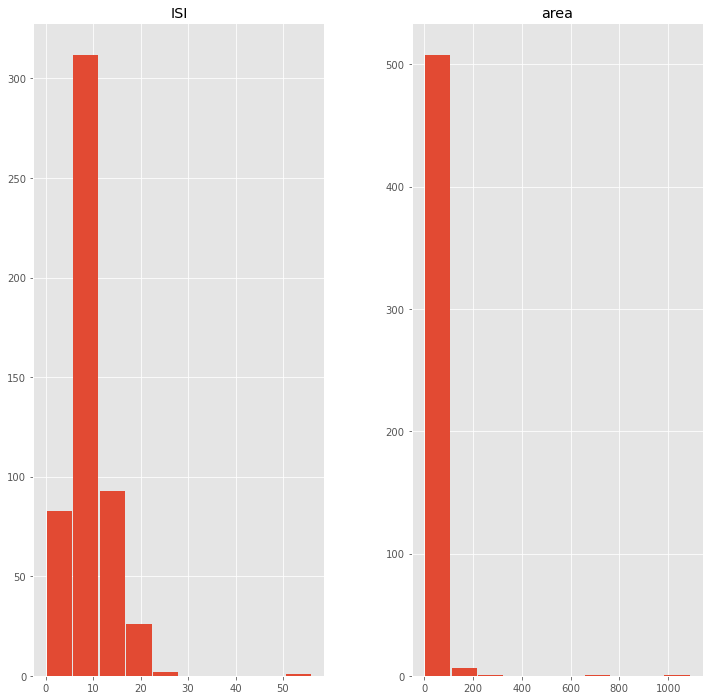

In [71]:
df_cleaned[['ISI', 'area']].hist(rwidth=0.95, figsize=(12,12))
plt.show()

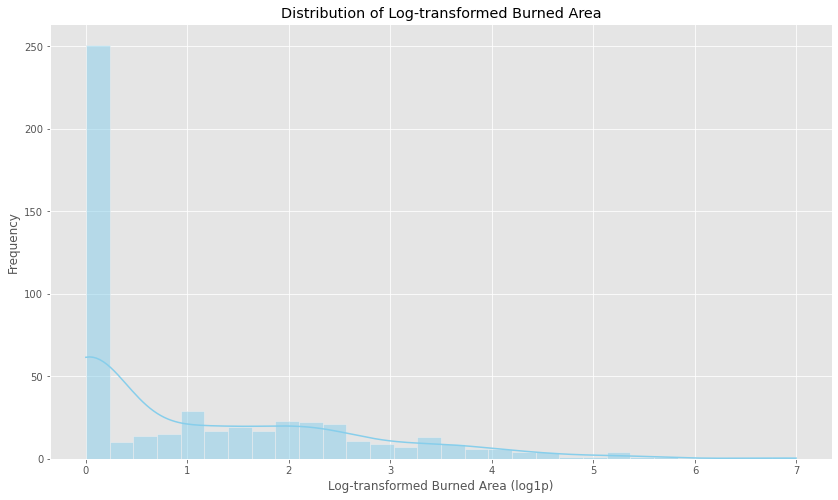

In [73]:
# np.log1p is used instead of np.log to handle zero values gracefully. log1p(x) computes log(1 + x), which is more stable for small values.

df_cleaned['log_burned_area'] = np.log1p(df_cleaned['area'])

# Plotting the distribution of the transformed burned area
plt.figure(figsize=(14, 8))
sns.histplot(df_cleaned['log_burned_area'], kde=True, bins=30, color='skyblue')

# Customize the plot
plt.title("Distribution of Log-transformed Burned Area")
plt.xlabel("Log-transformed Burned Area (log1p)")
plt.ylabel("Frequency")
plt.show()

## Where does most of the fire damage take place in this park?

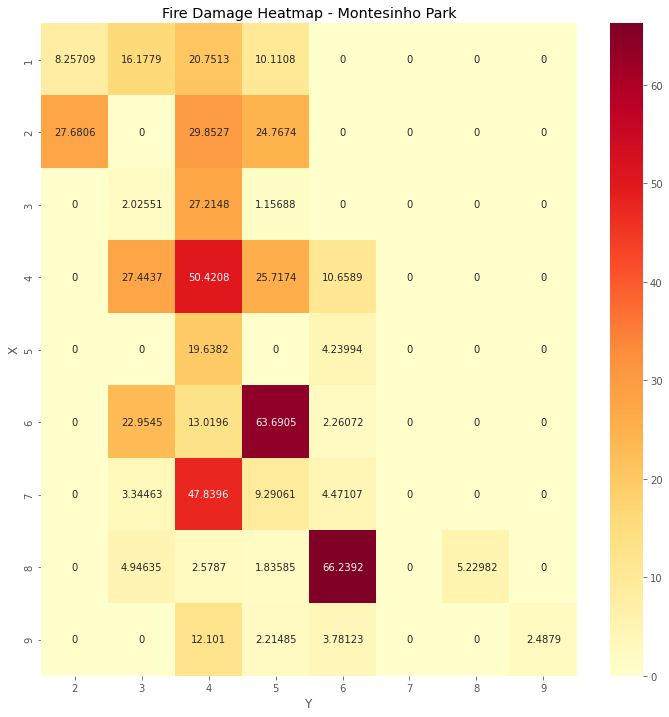

In [74]:
# Aggregate data to handle duplicate X, Y pairs (e.g., sum the burned areas)
df_agg = df_cleaned.groupby(['X', 'Y']).agg({'log_burned_area': 'sum'}).reset_index()

# Create a full grid for the park (assuming known X and Y ranges)
x_range = np.arange(df_agg['X'].min(), df_agg['X'].max() + 1)
y_range = np.arange(df_agg['Y'].min(), df_agg['Y'].max() + 1)
full_grid = pd.DataFrame([(x, y) for x in x_range for y in y_range], columns=['X', 'Y'])

# Merge the full grid with the aggregated data to fill in missing values
df_full = pd.merge(full_grid, df_agg, on=['X', 'Y'], how='left').fillna(0)

# Pivot the DataFrame to get X and Y as axes
heatmap_data = df_full.pivot('X', 'Y', 'log_burned_area')

# Generate the heatmap
plt.figure(figsize=(12,12))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='g')

plt.title("Fire Damage Heatmap - Montesinho Park")
plt.show()

## What time of year do the most fires occur?

In [75]:
df_cleaned['month'].unique(), df_cleaned['day'].unique()

(array(['mar', 'oct', 'aug', 'sep', 'apr', 'jun', 'jul', 'feb', 'jan',
        'dec', 'may', 'nov'], dtype=object),
 array(['fri', 'tue', 'sat', 'sun', 'mon', 'wed', 'thu'], dtype=object))

In [92]:
# Map months and days to numerical values
month_order = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
               'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
day_order = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5, 'sat': 6, 'sun': 7}

# Convert the month and day columns to numerical values
df_cleaned['month_num'] = df_cleaned['month'].map(month_order)
df_cleaned['day_num'] = df_cleaned['day'].map(day_order)

# Sort the DataFrame by month and then by day
df_sorted = df_cleaned.sort_values(by=['month_num', 'day_num'])

df_cleaned = df_cleaned[['X', 'Y',
 'month', 'month_num',
 'day', 'day_num',
 'FFMC', 'wind', 'ISI',
 'DMC', 'DC', 'BUI',
 'FWI',
 'area',
 'log_burned_area']].sort_values(by='month_num', ascending=True)

In [93]:
# Aggregate data to handle duplicate Month, Day pairs (e.g., sum the burned areas)
df_agg_time = df_sorted.groupby(['month', 'day'], sort=False).agg({'area': 'sum'}).reset_index()


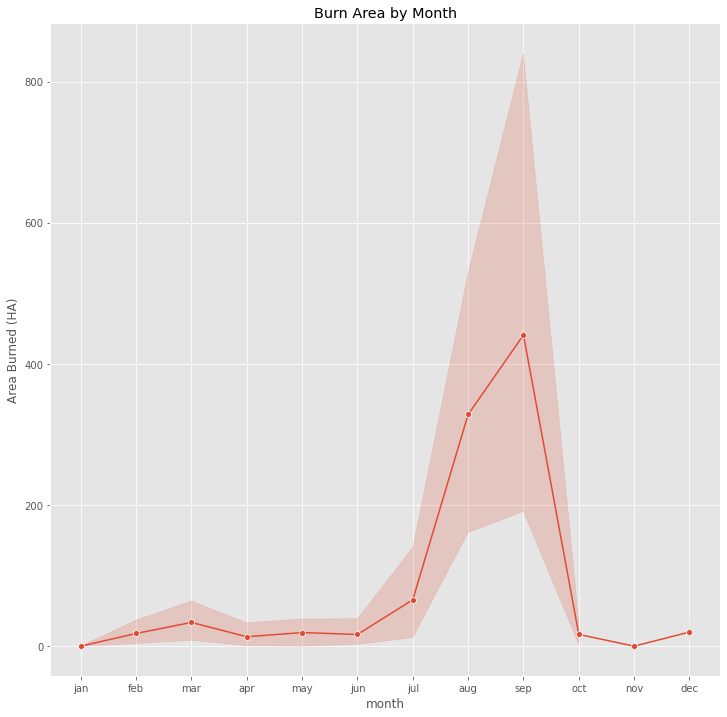

In [94]:
plt.figure(figsize=(12,12))

sns.lineplot(data=df_agg_time, x='month', y='area', marker='o', sort=False)

plt.title('Burn Area by Month')
plt.ylabel('Area Burned (HA)')
plt.show()

Summer time does really make sense. It also makes sense that it doesn't start until the end of the summer

## Were temperatures impacted by the location on the park?

(9.0, 0.0)

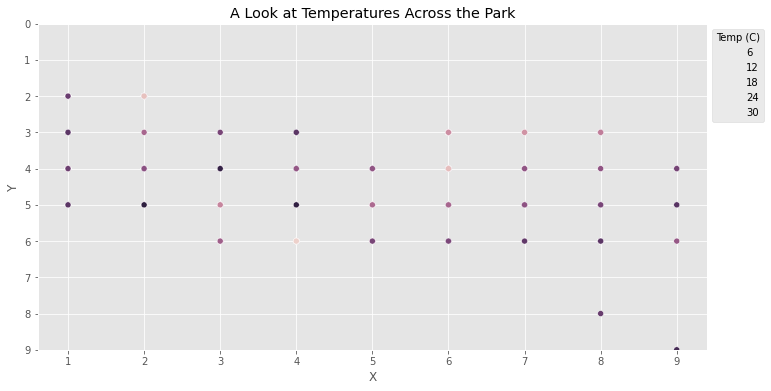

In [95]:
df_coords = df.sort_values(by=['X', 'Y'], ascending=False)
NY=df.Y.max()
NX=df.X.max()

plt.figure(figsize=(12,6))

g = sns.scatterplot(data=df_coords, x='X', y='Y', hue='temp')
plt.legend(title="Temp (C)")
plt.title("A Look at Temperatures Across the Park")
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(NY,0)
# plt.xlim(NX,0)


## Was there any extreme drought concerns?

In [116]:
df_cleaned['DC'].max()

860.6

In [113]:
df_cleaned[df_cleaned['DC'] >= 800]

,X,Y,month,month_num,day,day_num,FFMC,wind,ISI,DMC,DC,BUI,FWI,area,log_burned_area
384,8,4,aug,8,sat,6,91.6,4.5,7.7,273.8,819.1,1092.9,1100.6,12.18,2.578701
459,7,4,aug,8,sat,6,91.6,8.0,7.7,273.8,819.1,1092.9,1100.6,1.94,1.078410
453,4,5,aug,8,thu,4,89.4,3.1,5.6,266.2,803.3,1069.5,1075.1,0.00,0.000000
434,1,4,aug,8,fri,5,90.6,3.6,5.5,269.8,811.2,1081.0,1086.5,0.00,0.000000
440,5,4,sep,9,fri,5,90.3,3.6,7.4,290.0,855.3,1145.3,1152.7,0.00,0.000000
444,2,5,sep,9,fri,5,90.3,3.6,7.4,290.0,855.3,1145.3,1152.7,9.96,2.394252
430,7,4,sep,9,thu,4,89.7,3.6,6.8,287.2,849.3,1136.5,1143.3,0.00,0.000000
448,7,4,sep,9,wed,3,89.7,4.0,10.1,284.9,844.0,1128.9,1139.0,0.00,0.000000
406,6,5,sep,9,sat,6,87.1,4.9,4.0,291.3,860.6,1151.9,1155.9,3.95,1.599388
408,4,3,sep,9,fri,5,90.3,3.1,7.4,290.0,855.3,1145.3,1152.7,7.80,2.174752


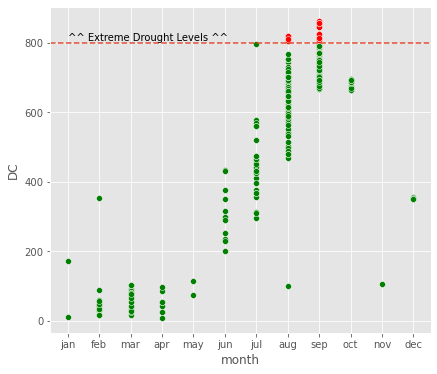

In [131]:
fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot(121)

sns.scatterplot(x='month', y='DC', data=df_cleaned, ax=ax1, color='green')

sns.scatterplot(x='month', y='DC',
            data=df_cleaned[df_cleaned['DC'] >= 800], color='red', ax=ax1)

ax1.axhline(800, ls='--')
ax1.text(0,805, "^^ Extreme Drought Levels ^^")

plt.show()

## A look at the FWI spread across the park

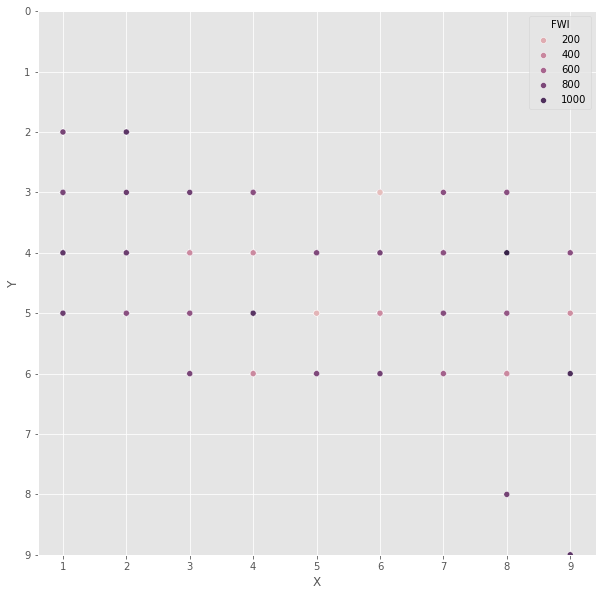

In [132]:
plt.figure(figsize=(10,10))

sns.scatterplot(data=df_cleaned, x='X', y='Y', hue='FWI')
plt.ylim(NY,0)

plt.show()

<Figure size 720x720 with 0 Axes>

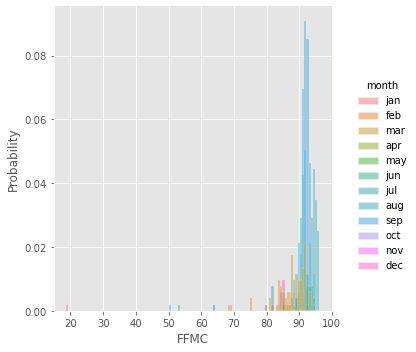

In [55]:
plt.figure(figsize=(10,10))

sns.displot(data=df_sorted, x='FFMC', hue="month", stat='probability')


sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.show()